Juan Andres Galicia 20298

Oscar Méndez 20402

# Laboratorio 6

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
users = pd.read_csv('Users.csv')
print(len(users))
users.head()

278858


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
books = pd.read_csv('Books.csv')
print(len(books))
books.head()

271360


C:\Users\osjom\AppData\Local\Temp\ipykernel_19648\3930219760.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
ratings = pd.read_csv('Ratings.csv')
print(len(ratings))
ratings.head()

1149780


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
ratings['Book-Rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

Podemos ver que cuando a la gente no le gusta algo lo más probable es que le ponga 0, pdoemos ver que del 1 al 4 los datos son exageradamente menores a comparacion del rating 0. Esto hay que tomarlo en cuanta para el modelo, ya que el desbalance es muy evidente.

## Collaborating Filtering

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, dot, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

In [8]:
data = pd.merge(pd.merge(ratings, users, on='User-ID'), books, on='ISBN')
len(data)

1031136

### Filtro

Para el sistema colaborativo solo incuimos a los libros que tienen al menos 20 ratings y a los usurios qu han rateado al menos 20 libros. Esto debido a que los algoritmos tienden a funcionar de esta forma, al principio las recomendaciones son solo tendencias locales, cuando el usuario ya va generando la data entonces ya se le aplica el algoritmo personalizado. Tambien es para reducir la cantidad de datos.

In [9]:
books_count = data.groupby("ISBN", as_index=False)[["User-ID"]].count().rename(columns={"User-ID": "book_count"})
users_count = data.groupby("User-ID", as_index=False)[["ISBN"]].count().rename(columns={"ISBN": "user_count"})
filtered_data = data.merge(books_count, on="ISBN").merge(users_count, on="User-ID")
filtered_data = filtered_data[(filtered_data.book_count >= 20) & (filtered_data.user_count >= 20)]
len(filtered_data)

284030

In [10]:
filtered_data["Book-Rating"].value_counts()

0     192894
8      22393
10     18661
9      16482
7      14936
5       8710
6       6736
4       1469
3        963
2        494
1        292
Name: Book-Rating, dtype: int64

### Procesamiento

In [11]:
filtered_data['ISBN'] = pd.Categorical(filtered_data['ISBN'])
filtered_data['ISBN'] = filtered_data['ISBN'].cat.codes

filtered_data['User-ID'] = pd.Categorical(filtered_data['User-ID'])
filtered_data['User-ID'] = filtered_data['User-ID'].cat.codes

In [12]:
rating_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 1,
    8: 1,
    9: 2,
    10: 2
}

filtered_data["Book-Rating-NPS"] = filtered_data["Book-Rating"].map(rating_map)

In [13]:
filtered_data["Book-Rating"] = pd.cut(filtered_data["Book-Rating"], bins=11, labels=list(range(11)))
filtered_data["Book-Rating-NPS"] = pd.cut(filtered_data["Book-Rating-NPS"], bins=3, labels=list(range(3)))
train, test = train_test_split(filtered_data, test_size=0.2, random_state=42)

### Modelo 1

Modelo multicategorico de 0 a 10, sin balacear ni utilizar pesos para mitigar el efecto de las clases desbalanceadas.

In [14]:
# Define embedding sizes
n_users = len(filtered_data['User-ID'].unique())
n_books = len(filtered_data['ISBN'].unique())
n_factors = 1

# Create the model
user_input = Input(shape=(1,))
user_embedding = Embedding(n_users, n_factors, embeddings_initializer='he_normal')(user_input)
user_vec = Flatten()(user_embedding)

book_input = Input(shape=(1,))
book_embedding = Embedding(n_books, n_factors, embeddings_initializer='he_normal')(book_input)
book_vec = Flatten()(book_embedding)

concat = Concatenate()([user_vec, book_vec])

x = Dense(50, activation='relu')(concat)

# Output layer with softmax activation for multi-categorical classification
result = Dense(11, activation='softmax')(x)

model_1 = Model(inputs=[user_input, book_input], outputs=result)
model_1.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_1.fit(
    [train["User-ID"], train["ISBN"]],
    train["Book-Rating"],
    batch_size=64,
    epochs=1,
    validation_data=([test["User-ID"], test["ISBN"]],test["Book-Rating"])
)

# Make predictions
predictions_1 = np.argmax(model_1.predict([test["User-ID"], test["ISBN"]]), axis=1)

print(classification_report(test["Book-Rating"], predictions_1, zero_division=np.nan))

1776/1776 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     38574
           1        nan      0.00       nan        63
           2        nan      0.00       nan       100
           3        nan      0.00       nan       211
           4        nan      0.00       nan       291
           5       0.62      0.12      0.20      1732
           6        nan      0.00       nan      1363
           7        nan      0.00       nan      2886
           8       0.26      0.05      0.08      4493
           9        nan      0.00       nan      3314
          10       0.30      0.06      0.10      3779

    accuracy                           0.69     56806
   macro avg       0.47      0.11      0.30     56806
weighted avg       0.63      0.69      0.68     56806



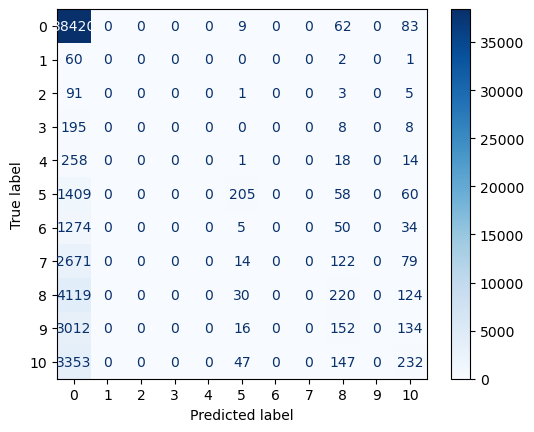

In [15]:
ConfusionMatrixDisplay.from_predictions(test["Book-Rating"], predictions_1, cmap='Blues')
plt.show()

No le fue muy bien, aunque si logra distinguir cuando al usuario no le gusta algo para nada y le pone 0 de rating.

### Modelo 2
Modelo multicategorico de 0 a 10, utilizando pesos para mitigar el efecto de las clases desbalanceadas.

In [275]:
class_weights_2 = compute_class_weight(class_weight="balanced", classes=np.unique(filtered_data["Book-Rating"]), y=filtered_data["Book-Rating"])
class_weights_2 = dict(enumerate((class_weights_2+1)/2))
class_weights_2

{0: 0.566930306517852,
 1: 44.71388542963886,
 2: 26.634523371365475,
 3: 13.906494855092985,
 4: 9.288600779751222,
 5: 1.9822565494207285,
 6: 2.4166351759879077,
 7: 1.364385012416614,
 8: 1.0765397465928883,
 9: 1.2833063066044499,
 10: 1.1918415168241008}

In [256]:
# Define embedding sizes
n_users = len(filtered_data['User-ID'].unique())
n_books = len(filtered_data['ISBN'].unique())
n_factors = 1

# Create the model
user_input = Input(shape=(1,))
user_embedding = Embedding(n_users, n_factors, embeddings_initializer='he_normal')(user_input)
user_vec = Flatten()(user_embedding)

book_input = Input(shape=(1,))
book_embedding = Embedding(n_books, n_factors, embeddings_initializer='he_normal')(book_input)
book_vec = Flatten()(book_embedding)

concat = Concatenate()([user_vec, book_vec])

x = Dense(50, activation='relu')(concat)

# Output layer with softmax activation for multi-categorical classification
result = Dense(11, activation='softmax')(x)

model_2 = Model(inputs=[user_input, book_input], outputs=result)
model_2.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_2.fit(
    [train["User-ID"], train["ISBN"]],
    train["Book-Rating"],
    batch_size=64,
    epochs=1,
    validation_data=([test["User-ID"], test["ISBN"]],test["Book-Rating"]),
    class_weight=class_weights
)

# Make predictions
predictions_2 = np.argmax(model_2.predict([test["User-ID"], test["ISBN"]]), axis=1)

print(classification_report(test["Book-Rating"], predictions_2, zero_division=np.nan))

1776/1776 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.97      0.82     38574
           1        nan      0.00       nan        63
           2        nan      0.00       nan       100
           3        nan      0.00       nan       211
           4        nan      0.00       nan       291
           5       0.17      0.32      0.23      1732
           6        nan      0.00       nan      1363
           7        nan      0.00       nan      2886
           8       0.11      0.00      0.00      4493
           9        nan      0.00       nan      3314
          10       0.24      0.08      0.12      3779

    accuracy                           0.67     56806
   macro avg       0.31      0.12      0.29     56806
weighted avg       0.60      0.67      0.67     56806



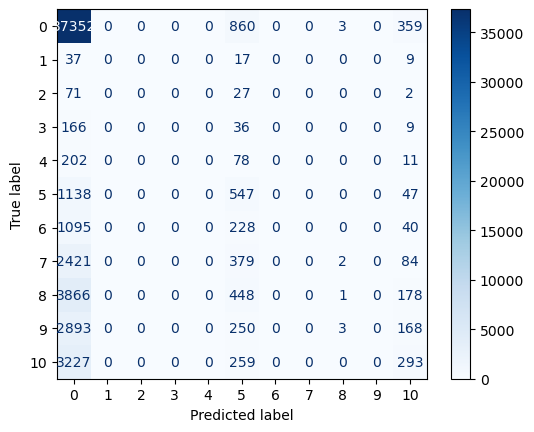

In [257]:
ConfusionMatrixDisplay.from_predictions(test["Book-Rating"], predictions_2, cmap='Blues')
plt.show()

Tampoco funciono muy bien, el rating 0 si lo distingue bien todavia, pero lo demas esta muy mal categorizado.

### Modelo 3

In [337]:
class_weights_3 = compute_class_weight(class_weight="balanced", classes=np.unique(filtered_data["Book-Rating-NPS"]), y=filtered_data["Book-Rating-NPS"])
class_weights_3 = dict(enumerate(class_weights_3))
class_weights_3

{0: 0.4475210895672424, 1: 2.5362765320974754, 2: 2.6940405391306}

In [349]:
# Define embedding sizes
n_users = len(filtered_data['User-ID'].unique())
n_books = len(filtered_data['ISBN'].unique())
n_factors = 1

# Create the model
user_input = Input(shape=(1,))
user_embedding = Embedding(n_users, n_factors, embeddings_initializer='he_normal')(user_input)
user_vec = Flatten()(user_embedding)

book_input = Input(shape=(1,))
book_embedding = Embedding(n_books, n_factors, embeddings_initializer='he_normal')(book_input)
book_vec = Flatten()(book_embedding)

concat = Concatenate()([user_vec, book_vec])

x = Dense(128, activation='relu')(concat)
x = Dense(64, activation='relu')(concat)


# Output layer with softmax activation for multi-categorical classification
result = Dense(3, activation='softmax')(x)

model_3 = Model(inputs=[user_input, book_input], outputs=result)
model_3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_3 = model_3.fit(
    [train["User-ID"], train["ISBN"]],
    train["Book-Rating-NPS"],
    batch_size=64,
    epochs=5,
    validation_data=([test["User-ID"], test["ISBN"]],test["Book-Rating-NPS"]),
    class_weight=class_weights_3
)

# Make predictions
predictions_3 = np.argmax(model_3.predict([test["User-ID"], test["ISBN"]]), axis=1)

print(classification_report(test["Book-Rating-NPS"], predictions_3, zero_division=np.nan))

Epoch 1/5
3551/3551 [==============================] - 10s 3ms/step - loss: 1.0376 - accuracy: 0.5163 - val_loss: 0.9671 - val_accuracy: 0.5806
Epoch 2/5
3551/3551 [==============================] - 8s 2ms/step - loss: 1.0028 - accuracy: 0.5965 - val_loss: 0.9798 - val_accuracy: 0.5487
Epoch 3/5
3551/3551 [==============================] - 8s 2ms/step - loss: 0.9916 - accuracy: 0.6027 - val_loss: 0.9638 - val_accuracy: 0.5875
Epoch 4/5
3551/3551 [==============================] - 8s 2ms/step - loss: 0.9842 - accuracy: 0.6162 - val_loss: 0.9746 - val_accuracy: 0.6125
Epoch 5/5
1776/1776 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.85      0.70      0.76     42334
           1       0.23      0.42      0.30      7379
           2       0.28      0.33      0.31      7093

    accuracy                           0.62     56806
   macro avg       0.45      0.48      0.46     56806
weighted avg       0.70      0.62 

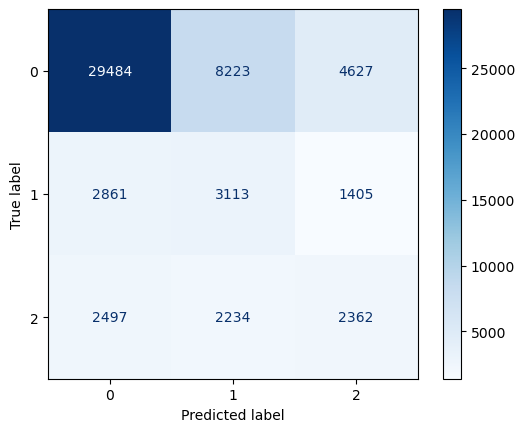

In [350]:
ConfusionMatrixDisplay.from_predictions(test["Book-Rating-NPS"], predictions_3, cmap='Blues')
plt.show()

Tampoco funciona muy bien de esta forma.